In [1]:
# --- 1. SET UP ENVIRONMENT ---
print("Creating folders 'outputs/' and 'csv_files/'...")
!mkdir outputs
!mkdir csv_files

# Install gdown to download Google Drive files
!pip install gdown -q

# --- 2. DOWNLOAD DATASETS ---
print("Downloading datasets...")
# Trader Data
!gdown "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs" -O trader_data.csv
# Sentiment Data
!gdown "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf" -O sentiment_data.csv

# --- 3. LOAD DATA INTO PANDAS ---
import pandas as pd
import numpy as np

print("\nLoading files into pandas...")
try:
    trader_df = pd.read_csv('trader_data.csv')
    sentiment_df = pd.read_csv('sentiment_data.csv')
    print("Files loaded successfully.")
    print("\n--- Trader Data Sample ---")
    print(trader_df.head())
    print("\n--- Sentiment Data Sample ---")
    print(sentiment_df.head())
except Exception as e:
    print(f"Error loading files: {e}")

Creating folders 'outputs/' and 'csv_files/'...
Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/trader_data.csv
100% 47.5M/47.5M [00:01<00:00, 40.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/sentiment_data.csv
100% 90.8k/90.8k [00:00<00:00, 28.3MB/s]

Loading files into pandas...
Files loaded successfully.

--- Trader Data Sample ---
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 

In [2]:
import pandas as pd
import numpy as np

# --- 4. PREPARE SENTIMENT DATA ---
print("Cleaning Sentiment data...")
# Use 'date' and 'classification' (lowercase) as seen in your sample
sentiment_df['Date'] = pd.to_datetime(sentiment_df['date'])

# Map 'classification' to a numerical score
classification_map = {
    'Extreme Fear': -2,
    'Fear': -1,
    'Neutral': 0,
    'Greed': 1,
    'Extreme Greed': 2 # Adding this in case it exists
}
sentiment_df['Sentiment_Score'] = sentiment_df['classification'].map(classification_map).fillna(0)
# We only need these columns for merging
sentiment_df_clean = sentiment_df[['Date', 'classification', 'Sentiment_Score']].copy()


# --- 5. PREPARE TRADER DATA ---
print("Cleaning Trader data...")
# Convert 'Timestamp IST' to datetime.
# We use dayfirst=True because of the error you saw (e.g., "18-03-2025")
trader_df['datetime'] = pd.to_datetime(trader_df['Timestamp IST'], dayfirst=True)

# Create a 'Date' column by removing the time component (for merging)
trader_df['Date'] = trader_df['datetime'].dt.floor('D')

# Ensure key columns are numeric (in case they loaded as text)
trader_df['Size USD'] = pd.to_numeric(trader_df['Size USD'], errors='coerce')
trader_df['Closed PnL'] = pd.to_numeric(trader_df['Closed PnL'], errors='coerce')


# --- 6. MERGE THE DATASETS ---
print("Merging datasets on 'Date'...")
merged_df = pd.merge(trader_df, sentiment_df_clean, on='Date', how='left')


# --- 7. CREATE 'daily_summary' (THE CORRECTED STEP) ---
print("Aggregating data by day...")
# We group by day and sentiment.
# We REMOVED 'leverage' since it's not in the file.
daily_summary = merged_df.groupby(['Date', 'classification', 'Sentiment_Score']).agg(
    total_volume_usd=('Size USD', 'sum'),
    net_pnl=('Closed PnL', 'sum'),
    trade_count=('Account', 'count'),
    pnl_volatility=('Closed PnL', 'std')
).reset_index()

# Handle NaNs from std dev calculation (for days with only 1 trade)
daily_summary['pnl_volatility'] = daily_summary['pnl_volatility'].fillna(0)

print("\n--- Daily Summary Created ---")
print(daily_summary.head())


# --- 8. SAVE THE SUMMARY FILE ---
try:
    daily_summary.to_csv('csv_files/daily_behavior_summary.csv', index=False)
    print("\nSuccessfully saved 'daily_behavior_summary.csv' to 'csv_files/' folder.")
except Exception as e:
    print(f"\nError saving CSV: {e}")

Cleaning Sentiment data...
Cleaning Trader data...
Merging datasets on 'Date'...
Aggregating data by day...

--- Daily Summary Created ---
        Date classification  Sentiment_Score  total_volume_usd     net_pnl  \
0 2023-05-01          Greed              1.0            477.00    0.000000   
1 2023-12-05  Extreme Greed              2.0          50005.83    0.000000   
2 2023-12-14          Greed              1.0         113203.35 -205.434737   
3 2023-12-15          Greed              1.0          10609.95  -24.632034   
4 2023-12-16          Greed              1.0          15348.77    0.000000   

   trade_count  pnl_volatility  
0            3        0.000000  
1            9        0.000000  
2           11      179.663534  
3            2        4.474304  
4            3        0.000000  

Successfully saved 'daily_behavior_summary.csv' to 'csv_files/' folder.


Generating and saving plots...
Saved '1_volume_vs_sentiment.png' to 'outputs/'


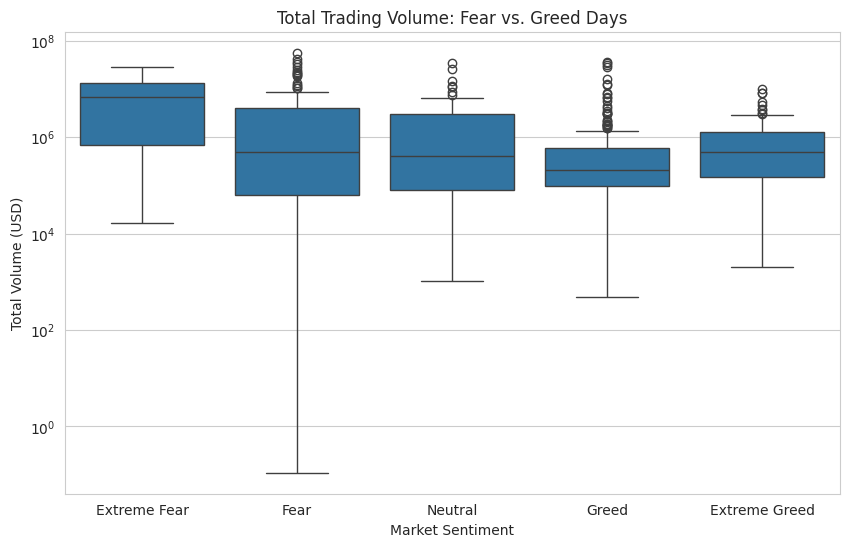

Saved '2_pnl_vs_sentiment.png' to 'outputs/'


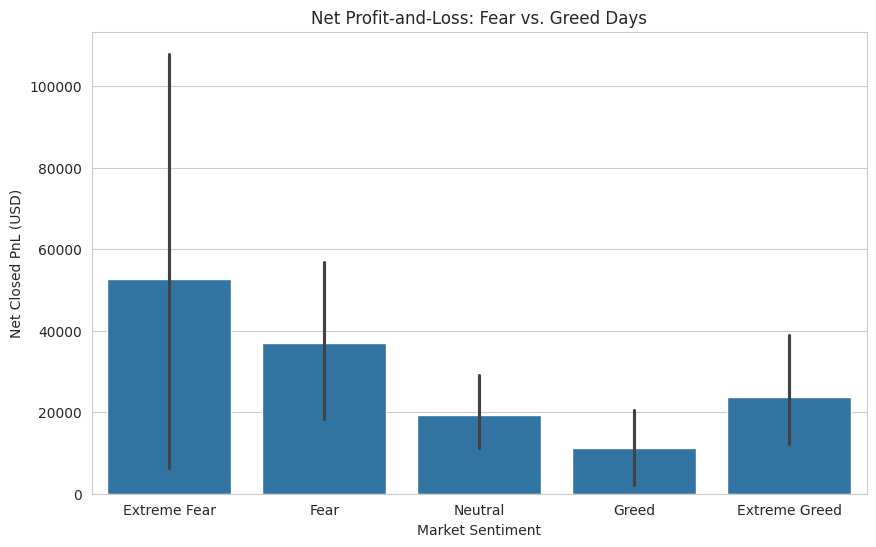

Saved '3_risk_vs_sentiment.png' to 'outputs/'


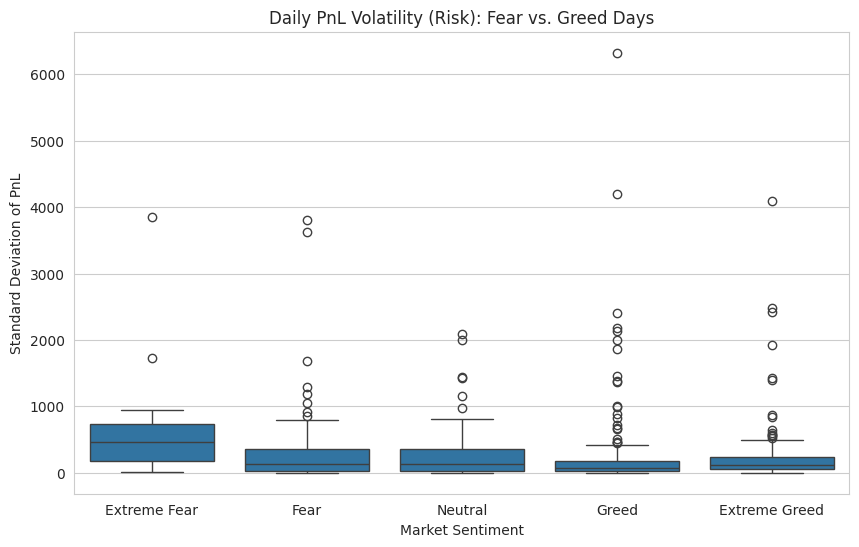

Saved '4_correlation_heatmap.png' to 'outputs/'


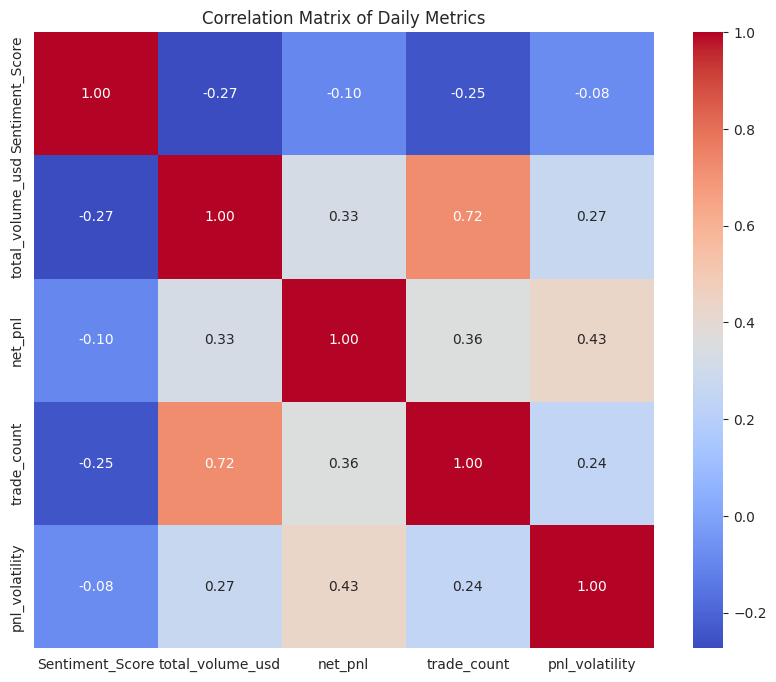


All analysis complete and plots saved.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Generating and saving plots...")
sns.set_style("whitegrid")

# --- 1. Analyze Volume vs. Sentiment ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=daily_summary, x='classification', y='total_volume_usd',
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Total Trading Volume: Fear vs. Greed Days')
plt.xlabel('Market Sentiment')
plt.ylabel('Total Volume (USD)')
plt.yscale('log') # Use log scale if volume is highly skewed
plt.savefig('outputs/1_volume_vs_sentiment.png')
print("Saved '1_volume_vs_sentiment.png' to 'outputs/'")
plt.show()

# --- 2. Analyze Profitability vs. Sentiment ---
plt.figure(figsize=(10, 6))
sns.barplot(data=daily_summary, x='classification', y='net_pnl',
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Net Profit-and-Loss: Fear vs. Greed Days')
plt.xlabel('Market Sentiment')
plt.ylabel('Net Closed PnL (USD)')
plt.savefig('outputs/2_pnl_vs_sentiment.png')
print("Saved '2_pnl_vs_sentiment.png' to 'outputs/'")
plt.show()

# --- 3. Analyze Risk (PnL Volatility) vs. Sentiment ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=daily_summary, x='classification', y='pnl_volatility',
            order=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])
plt.title('Daily PnL Volatility (Risk): Fear vs. Greed Days')
plt.xlabel('Market Sentiment')
plt.ylabel('Standard Deviation of PnL')
plt.savefig('outputs/3_risk_vs_sentiment.png')
print("Saved '3_risk_vs_sentiment.png' to 'outputs/'")
plt.show()

# --- 4. Correlation Analysis ---
# We select only the numeric columns for correlation
numeric_summary = daily_summary[['Sentiment_Score', 'total_volume_usd', 'net_pnl', 'trade_count', 'pnl_volatility']]
correlation_matrix = numeric_summary.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Daily Metrics')
plt.savefig('outputs/4_correlation_heatmap.png')
print("Saved '4_correlation_heatmap.png' to 'outputs/'")
plt.show()

print("\nAll analysis complete and plots saved.")